#**Imports**

In [ ]:
#from google.colab import drive
import pandas as pd
import numpy as np
import random
from pandas import Timestamp
from matplotlib import pyplot as plt

import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVC

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import neighbors

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor

##**Retrieve .csvs**:

In [ ]:
## From GitHub

gta_item_spend_link = 'https://raw.githubusercontent.com/oyrange/GTA-Screentime/main/item_spend.csv'
gta_item_spend = pd.read_csv(gta_item_spend_link,
                             parse_dates=['occur_date'])

gta_activity_link = 'https://raw.githubusercontent.com/oyrange/GTA-Screentime/main/player_activity.csv'
gta_player_activity = pd.read_csv(gta_activity_link,
                             parse_dates=['occur_date'])

gta_statistics_link = 'https://raw.githubusercontent.com/oyrange/GTA-Screentime/main/player_statistics.csv'
gta_player_statistics = pd.read_csv(gta_statistics_link,
                             parse_dates=['occur_date', 'first_day_played'])

In [ ]:
len(gta_player_activity) + len(gta_player_statistics) + len(gta_item_spend)

1247505

# **Function and Variable Documentation:**

### *`gta_account_ids` and `gta_occur_dates` represent only ids and dates occurring in **all three** CSVs:*

In [ ]:
### Unique `account_id`s appearing in ALL three csvs:

gta_account_ids = np.intersect1d(gta_player_statistics['account_id'],
                                 np.intersect1d(gta_item_spend['account_id'],
                                                gta_player_activity['account_id'])
                                 )

print(f'There are {len(gta_account_ids)} `account_id`s appearing in ALL three \n \
csvs, look them up in gta_account_ids \n')


### Unique `occur_date`s appearing in ALL three csvs:

gta_occur_dates = np.intersect1d(gta_player_statistics['occur_date'],
                                  np.intersect1d(gta_item_spend['occur_date'],
                                                gta_player_activity['occur_date'])
                                )

print(f'There are {len(gta_occur_dates)} `occur_date`s appearing in ALL three \n \
csvs, look them up in gta_occur_dates')

There are 8772 `account_id`s appearing in ALL three 
 csvs, look them up in gta_account_ids 

There are 91 `occur_date`s appearing in ALL three 
 csvs, look them up in gta_occur_dates


## *Functions*:

In [ ]:
random_state = 8


def process_sums_ratios(df, cols_of_interest, iterations=gta_account_ids):
  """
  Sums and find ratios of cols_of_interest,
    returns them as a df indexed by iterations (default is gta_account_ids).
  """
  totals_array = []
  ratios_array = []
  trimmed_df = df[cols_of_interest]
  for id in iterations:
    ## Only values in df referencing ID.
    id_df = find_subset_in_df('account_id', id, trimmed_df) #dict_df[id]

    ## Totals
    totals = {col+' total': id_df[col].sum()
              for col
              in cols_of_interest}
    totals_array.append(totals)

    ## Ratios
    ratios = {col+' ratio': calculate_listlike_ratio(id_df[col])
            for col
            in cols_of_interest}
    ratios_array.append(ratios)

  ## Join into one DF
  totals_and_ratios_df = pd.DataFrame(totals_array, index=iterations) \
                          .join(pd.DataFrame(ratios_array, index=iterations))

  return totals_and_ratios_df


def process_item_types(df, processing_col='item_type', iterations=gta_account_ids):
  """
  Designed to return totals of each item type category per account_id.
  """
  concise_df = df[['account_id', processing_col]]
  array = []
  for id in iterations:
    id_df = find_subset_in_df('account_id', id, df)
    grouped = id_df.groupby(['account_id', processing_col]) \
                          .size() \
                          .reset_index()
    processed_dict = {item: size
                      for item, size
                      in zip(grouped[processing_col], grouped[0])}
    array.append(processed_dict)
  item_df = pd.DataFrame(array, index=iterations)
  return item_df


def find_subset_in_df(subset_col, desired_value, df):
  """
  Returns subset of `df` where `subset_col`
    is `desired_value`.
  """
  subset_df = df[df[subset_col] == desired_value]
  return subset_df


def calculate_listlike_ratio(series):
  """
  Sum series and divide it by length of itself.
  """
  ratio = np.sum(series) / len(series)
  return np.round(ratio, 2)


def process_ratios(df, cols_of_interest, iterations=gta_account_ids):
  """
  Find ratios of cols_of_interest,
    returns a df indexed by iterations (default is gta_account_ids).
  """
  ratios_array = []
  trimmed_df = df[cols_of_interest]

  for id in iterations:
    ## Only values in df referencing ID.
    id_df = find_subset_in_df('account_id', id, trimmed_df) #dict_df[id]

    ## Ratios
    ratios = {col+' ratio': calculate_listlike_ratio(id_df[col])
            for col
            in cols_of_interest}
    ratios_array.append(ratios)

  ratios_df = pd.DataFrame(ratios_array, index=iterations)
  return ratios_df


def process_sums(df, cols_of_interest, iterations=gta_account_ids):
  """
  Find ratios of cols_of_interest,
    returns new df of ratios, indexed by iterations
    (default is gta_account_ids).
  """
  totals_array = []
  trimmed_df = df[cols_of_interest]

  for id in iterations:
    ## Only values in df referencing ID.
    id_df = find_subset_in_df('account_id', id, trimmed_df) #dict_df[id]

    ## Totals
    totals = {col+' total': id_df[col].sum()
              for col
              in cols_of_interest}
    totals_array.append(totals)

  totals_df = pd.DataFrame(totals_array, index=iterations)
  return totals_df

def concatenate_into_series(*args):
  """
  Creates a concatenated series from unlimited *args.
  """
  concatenated_series = pd.concat(list(args))
  return concatenated_series


# Reference Lab 3
# The dataframe passed to VIF must include the intercept term. We add it the same way we did before.
def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)

## *Variables*:

CSVs:

- gta_item_spend
- gta_player_activity
- gta_player_statistics
- gta_csvs_dict

Columns For Processing
- activity_cols_of_interest
- items_cols_of_interest
- statistics_cols_of_interest

Processed CSV Data
- processed_activity - DF containing summed and ratioed (player data / length that player was recorded) columns in activity_cols_of_interest
- processed_items - DF containing counts of item categories purchased, for each player
- processed_stats - DF containing summed columns from statistics_cols_of_interest

#**Data Processing**

## *Fill Incorrect values*

In [ ]:
## The missing values in this specific dataset are only cars.
gta_item_spend['item_type'] = gta_item_spend['item_type'].fillna('CAR')

In [ ]:
#Correct improper vehicle names
improper_names = {
    "Imponte Duke O�Death": "Imponte Duke O'Death",
    "Lampadati�Viseris": "Lampadati Viseris",
    "Albany Fr�nken Stange": "Albany Fränken Stange",
    "P-45�Nokota": "P-45 Nokota"
}

gta_item_spend['item'] = gta_item_spend['item'].replace(improper_names)

##*Create DFs of Processed Interest Data*

In [ ]:
# Player Activity CSV
activity_cols_of_interest = ['account_id', 'kills', 'deaths', 'money_earned',
                             'rp_earned', 'success', 'money_vs_time_spent',
                             'rp_vs_time_spent', 'time_spent']

# Item Spend CSV
item_cols_of_interest = ['account_id', 'item_type']

# Player Statistics CSV
statistics_cols_of_interest = ['account_id', 'ltd_days_played', 'evc_balance',
                               'pvc_balance', 'char_rank', 'daily_playtime']

In [ ]:
## Runtime is approx 1.5 minutes

processed_activity = process_sums_ratios(gta_player_activity,
                                  activity_cols_of_interest)
processed_items = process_item_types(gta_item_spend)
processed_stats = process_sums(gta_player_statistics,
                               statistics_cols_of_interest) \
                               .join(gta_player_statistics.groupby('account_id')
                                        ['char_rank'].max())

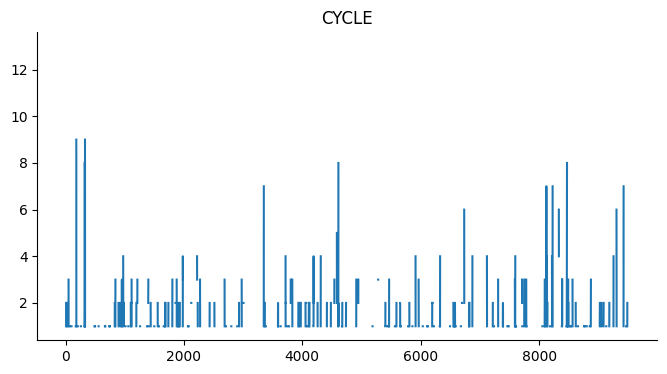

In [ ]:
# @title CYCLE

from matplotlib import pyplot as plt
processed_items['CYCLE'].plot(kind='line', figsize=(8, 4), title='CYCLE')
plt.gca().spines[['top', 'right']].set_visible(False)

# **Modelling**:

##*Features*

###*Feature Exploration*

In [ ]:
processed_activity.columns.tolist()
# processed_items.columns.tolist()
# processed_stats.columns.tolist()

['account_id total',
 'kills total',
 'deaths total',
 'money_earned total',
 'rp_earned total',
 'success total',
 'money_vs_time_spent total',
 'rp_vs_time_spent total',
 'time_spent total',
 'account_id ratio',
 'kills ratio',
 'deaths ratio',
 'money_earned ratio',
 'rp_earned ratio',
 'success ratio',
 'money_vs_time_spent ratio',
 'rp_vs_time_spent ratio',
 'time_spent ratio']

<Axes: >

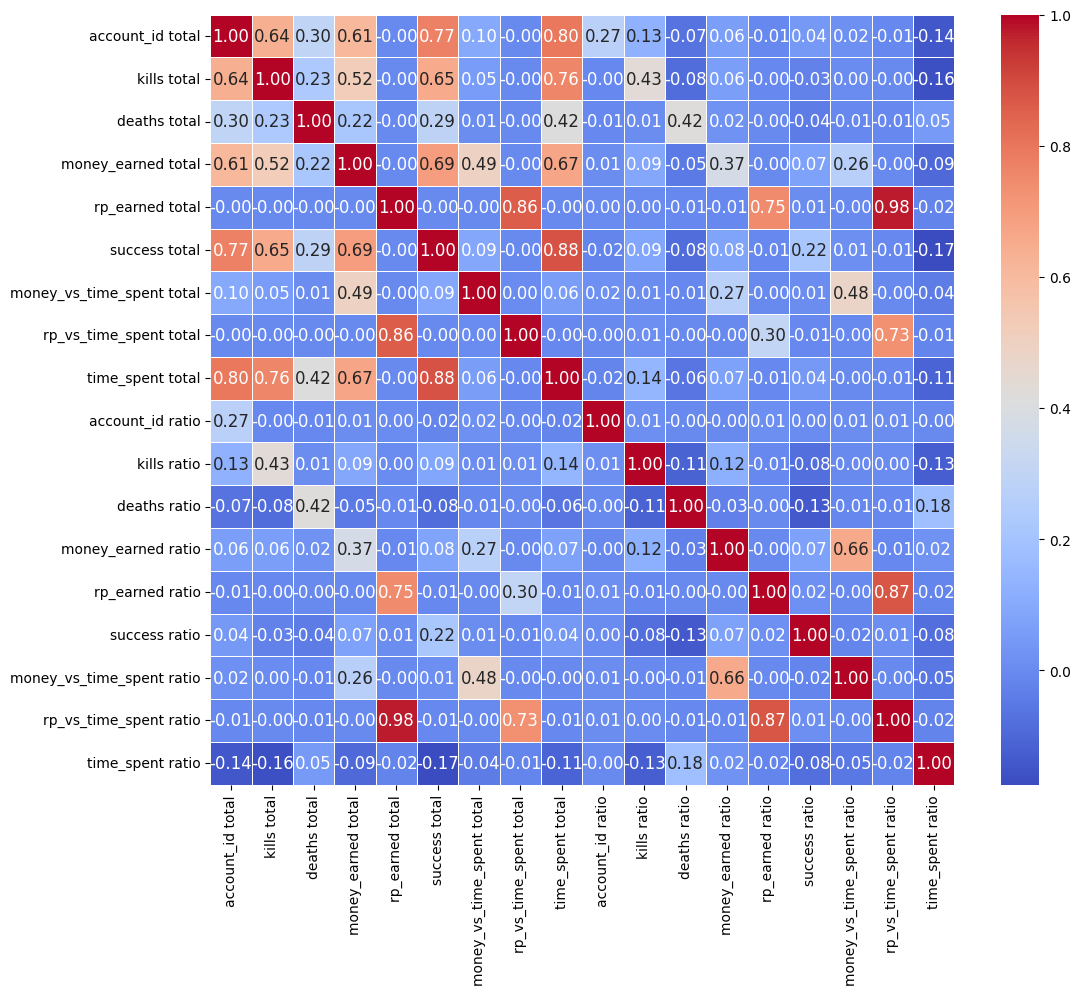

In [ ]:
corr = processed_activity.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={"size": 12}, cmap='coolwarm', linewidths=.5)

In [ ]:
processed_data = processed_activity[selected_features + [target]] \
                    .join(pd.DataFrame(processed_items.sum(axis='columns'))) \
                    .join(processed_stats)
processed_data['char_rank highest'] = gta_player_statistics.groupby('account_id')['char_rank'].max()

In [ ]:
processed_data

,kills total,money_earned total,success total,time_spent total,0,account_id total,ltd_days_played total,evc_balance total,pvc_balance total,char_rank total,daily_playtime total,char_rank highest
0,236,4.424020e+04,14,134.700495,22.0,0,6844,1.008279e+07,163047.677191,1329,10.101785,36
1,71,1.066346e+05,44,129.793234,4.0,39,5206,9.559764e+05,0.000000,1534,13.870489,44
2,33,6.118414e+05,29,159.093987,12.0,82,3198,1.104105e+07,0.000000,762,17.796335,23
3,10,1.116525e+06,75,287.686893,20.0,102,943,1.492467e+07,984721.370600,674,22.613138,28
4,0,5.196781e+03,0,17.958095,44.0,104,14761,1.678057e+06,0.000000,2566,14.678832,100
...,...,...,...,...,...,...,...,...,...,...,...,...
9522,0,7.561316e+02,1,4.545949,10.0,190440,795,2.352101e+07,0.000000,197,2.465090,10
9523,0,1.195260e+04,23,41.390627,3.0,95230,968,8.267912e+09,0.000000,549,4.248382,56
9524,105,1.229039e+02,1,18.683499,3.0,133336,3223,2.414774e+06,0.000000,574,6.578154,41
9525,0,9.094366e+02,0,5.225844,1.0,95250,9263,1.168961e+07,0.000000,1140,0.578406,114


<Axes: >

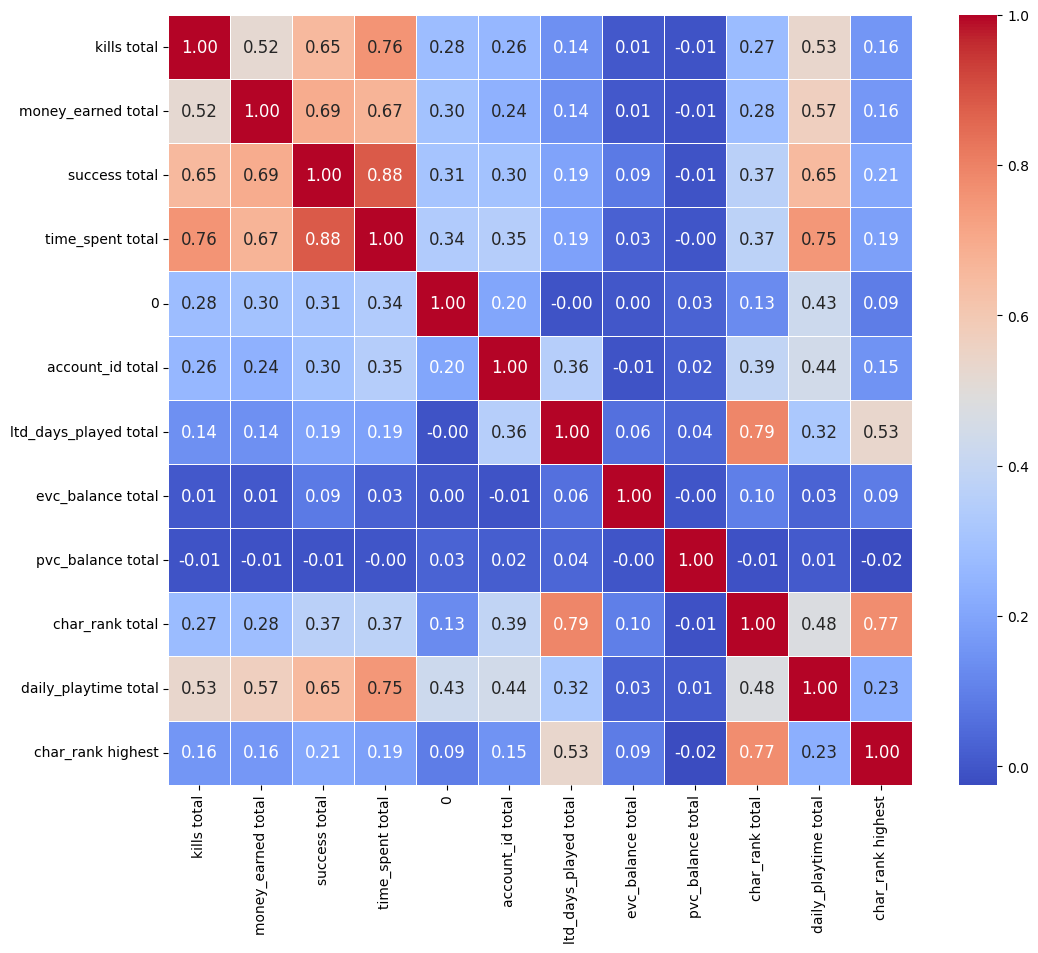

In [ ]:
all_corr = processed_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(all_corr, annot=True, fmt=".2f", annot_kws={"size": 12}, cmap='coolwarm', linewidths=.5)

### *Feature Selection*

In [ ]:
target = 'time_spent total'
selected_features = ['kills total', 'money_earned total', 'success total']

X = processed_activity[selected_features]
y = processed_activity[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##***Baseline Model*** -- 25-30% accuracy

Predict a random value within one standard deviation of the mean and median of the actual value.

Average accuracy is ~25%.

In [ ]:
#mean/median and standard deviation of variable
mean, median, std = y.mean(), \
                    y.median(), \
                    y.std()

#upper and lower limits
upper_mean, upper_median = (mean + std), \
                           (median + std)
lower_mean, lower_median = max(mean-std, 0), \
                           max(median-std, 0)


#performance of the baseline
baseline_pred_mean = np.where(y > mean, \
                                random.choice(np.arange(mean, upper_mean)),
                                random.choice(np.arange(lower_mean, mean)))

baseline_pred_median = np.where(y > mean,
                                    random.choice(np.arange(median, upper_median)),
                                    random.choice(np.arange(lower_median, median)))


# MSE, MAE, R2 Score
mse_bl_mean = mean_squared_error(y, baseline_pred_mean)
mae_bl_mean = mean_absolute_error(y, baseline_pred_mean)
r2_bl_mean = r2_score(y, baseline_pred_mean)

mse_bl_median = mean_squared_error(y, baseline_pred_median)
mae_bl_median = mean_absolute_error(y, baseline_pred_median)
r2_bl_median = r2_score(y, baseline_pred_median)

print(f"MSE (Mean): {mse_bl_mean}")
print(f"MAE (Mean): {mse_bl_mean}")
print(f"R2 Score (Mean): {r2_bl_mean}")
print(f"Baseline Model Accuracy (Mean): {np.round(r2_bl_mean * 100, 2)}% \n")

print(f"MSE (Median): {mse_bl_median}")
print(f"MAE (Median): {mse_bl_median}")
print(f"R2 Score (Median): {r2_bl_median}")
print(f"Baseline Model Accuracy (Median): {np.round(r2_bl_median * 100, 2)}%")

MSE (Mean): 83408.13237131125
MAE (Mean): 83408.13237131125
R2 Score (Mean): 0.29135713423644183
Baseline Model Accuracy (Mean): 29.14% 

MSE (Median): 109420.87037988885
MAE (Median): 109420.87037988885
R2 Score (Median): 0.07035061263381381
Baseline Model Accuracy (Median): 7.04%


##***Random Forest Regression*** -- 82% accuracy

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
forest_regressor_r2 = r2_score(y_test, y_pred)

y_pred, mse, forest_regressor_r2

print(f'Forest Regressor Model accuracy is: {np.round(forest_regressor_r2, 2) * 100}%')

Forest Regressor Model accuracy is: 82.0%


## ***Lasso Regression*** -- 84% accuracy

In [ ]:
lasso_reg = linear_model.Lasso(alpha=50, max_iter=100, tol=0.1)

lasso_reg.fit(X_train, y_train)
lasso_reg.score(X_test, y_test)
lasso_test_prediction_score = lasso_reg.score(X_test, y_test)

print(f'LASSO Model accuracy is: {np.round(lasso_test_prediction_score, 2) * 100}%')

LASSO Model accuracy is: 84.0%


##***Ridge Regression*** -- 83% accuracy

In [ ]:
ridge_regression = Ridge(alpha = 50, max_iter = 100, tol = 0.1)


ridge_regression.fit(X_train, y_train)
ridge_regression.score(X_test, y_test)
ridge_test_prediction_score = ridge_regression.score(X_test, y_test)

print(f'RIDGE Model accuracy is: {np.round(ridge_test_prediction_score, 2) * 100}%')

RIDGE Model accuracy is: 83.0%
